In [ ]:
import models
from models import Crane
from models.prompt_ensemble import PromptLearner
from dataset.dataset import Dataset
from __init__ import DATASETS_ROOT

from utils.transform import get_transform
from utils.loss import FocalLoss, BinaryDiceLoss
from utils.logger import get_logger
from utils.similarity import calc_similarity_logits, regrid_upsample
from utils import (
    setup_seed,
    seed_worker,
    turn_gradient_off,
    str2bool,
    prepare_encode_image_module,
    precompute_image_features,
    CustomTensorDataset
)

import sys
import os
import argparse
import subprocess

from tqdm import tqdm

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.16). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
import torchvision.transforms as transforms
import torch
def _convert_to_rgb(image):
    return image.convert('RGB')

args_image_size = 518
def image_transform(image_size, mean, std):
    normalize = transforms.Normalize(mean=mean, std=std)
    tnsfrms = [
        transforms.Resize(size=(image_size, image_size), interpolation=transforms.InterpolationMode.BICUBIC),
        # transforms.CenterCrop(image_size), # NOTE: No need for centercrop
        _convert_to_rgb,
        transforms.ToTensor(),
        normalize,
    ]
    return transforms.Compose(tnsfrms)

OPENAI_DATASET_MEAN = (0.48145466, 0.4578275, 0.40821073)
OPENAI_DATASET_STD = (0.26862954, 0.26130258, 0.27577711)


preprocess = image_transform(args_image_size, mean = OPENAI_DATASET_MEAN, std = OPENAI_DATASET_STD)

target_transform = transforms.Compose([
    transforms.Resize((args_image_size, args_image_size)),
    # transforms.CenterCrop(args.image_size), # NOTE: No need for centercrop
    transforms.ToTensor()
])

In [3]:
class Args:
    def __init__(self):
        self.aug_rate = 0.0
        self.portion = 1
        self.k_shot = 0
        self.type = "train"

In [4]:
args = Args()

In [5]:
args_datasets_root_dir = f"{DATASETS_ROOT}"
args_dataset = ["nail_dataset_v5_train"]
args_tarin_data_path = [f"{args_datasets_root_dir}/{ds}/" for ds in args_dataset]
# args = {"aug_rate" : 0.0, "portion": 1.0, "k_shot": 0, "type" : "train", }
train_data = Dataset(roots=args_tarin_data_path, transform=preprocess, 
                        target_transform=target_transform, dataset_name=args,
                        kwargs=args)

number of samples: 58


In [7]:
train_data.data_all[0]

{'img_path': 'test/nail/fault/PAD_4_11_1.jpg',
 'mask_path': 'test/nail/masks/PAD_4_11_1.jpg',
 'cls_name': 'nail',
 'specie_name': 'fault',
 'anomaly': 1,
 'root': '/workspace/data/nail_dataset_v5_train/'}

In [8]:
args_seed = 111
args_batch_size = 8
g = torch.Generator()
g.manual_seed(args_seed)
train_dataloader = DataLoader(train_data, batch_size=args_batch_size, shuffle=True, 
                                            num_workers=16, pin_memory=True, prefetch_factor=2,
                                            generator=g, worker_init_fn=seed_worker)  # Faster
print(f"Length of the dataset: {len(train_data)}")


Length of the dataset: 58


In [9]:
with tqdm(train_dataloader) as batch_tqdm:
    for items in batch_tqdm:
        label =  items['anomaly']
        abnorm_mask = items['abnorm_mask'].squeeze()
        break

  0%|          | 0/8 [00:05<?, ?it/s]


In [14]:
label

tensor([0, 0, 0, 0, 0, 1, 0, 0])

In [11]:
import matplotlib.pyplot as plt

In [ ]:
plt.show(abnorm_mask.cpu()[0].to_numpy(), cmap=""

torch.Size([518, 518])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..1.6055346].


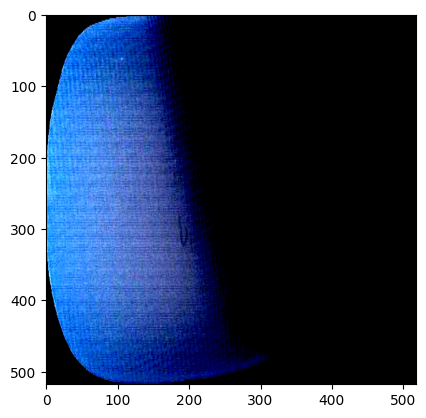

In [17]:
plt.imshow(items["img"].cpu()[-3].numpy().transpose(1, 2, 0))

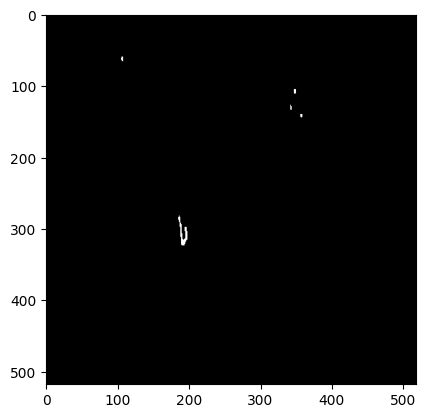

In [18]:
plt.imshow(abnorm_mask.cpu()[-3].numpy(), cmap="gray")